# Traveling Salesman Problem with Genetic Algorithm

This notebook demonstrates how to solve the Traveling Salesman Problem using the genetic algorithm implemented in `src/lib/ga.py`.

In [ ]:
# Add path to the central init_notebook.py file (just 5 lines!)
import sys
from pathlib import Path

doc_dir = Path().absolute().parent  # This points to the doc/ directory
if str(doc_dir) not in sys.path:
    sys.path.insert(0, str(doc_dir))

# Now import everything with one line
from notebook import GeneticAlgorithm, AssetType, am, torch, np, plt

from dataclasses import dataclass
from typing import List, Tuple
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Added c:\Users\fire\Documents\Code\python\ai to Python path
Set random seeds to 42


In [2]:
@dataclass
class TSPData:
    """Clase para almacenar los datos del problema del viajante (TSP)"""

    cities: torch.Tensor  # Coordenadas de las ciudades [num_cities, 2]
    distances: torch.Tensor  # Matriz de distancias [num_cities, num_cities]
    city_names: List[str] = None  # Nombres de las ciudades (opcional)

In [3]:
def create_random_tsp_instance(
    num_cities: int, max_coordinate: float = 100.0
) -> TSPData:
    """
    Crea una instancia aleatoria del problema del viajante

    Args:
        num_cities: Número de ciudades
        max_coordinate: Valor máximo para las coordenadas

    Returns:
        Datos del problema TSP
    """
    # Generar coordenadas aleatorias para las ciudades
    cities = torch.rand(num_cities, 2) * max_coordinate

    # Calcular matriz de distancias euclidiana
    distances = torch.zeros(num_cities, num_cities)
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                distances[i, j] = torch.sqrt(torch.sum((cities[i] - cities[j]) ** 2))

    # Crear nombres de ciudades
    city_names = [f"Ciudad {i + 1}" for i in range(num_cities)]

    return TSPData(cities=cities, distances=distances, city_names=city_names)

In [4]:
def decode_tsp_chromosome(chromosome: torch.Tensor, num_cities: int) -> List[int]:
    """
    Decodifica un cromosoma para el problema TSP

    La representación que utilizamos es 'order-based', donde cada gen tiene un valor entre 0 y 1,
    y la ruta se determina ordenando estos valores.

    Args:
        chromosome: Tensor cromosoma [num_cities]
        num_cities: Número de ciudades

    Returns:
        Lista de índices de ciudades (ruta)
    """
    # Usar argsort para obtener los índices en el orden de los valores
    route = torch.argsort(chromosome).tolist()
    return route


def tsp_fitness(population: torch.Tensor, problem_data: TSPData) -> torch.Tensor:
    """
    Función de fitness para el problema del viajante
    Para cada ruta (permutación de ciudades), calculamos la distancia total
    y convertimos ese valor a fitness (menor distancia = mayor fitness)

    Args:
        population: Tensor de población [pop_size, num_cities]
                   Cada cromosoma representa un orden de visita de las ciudades
        problem_data: Datos del problema TSP

    Returns:
        Tensor con los valores de fitness para cada ruta [pop_size]
    """
    pop_size, num_cities = population.shape
    fitness = torch.zeros(pop_size)

    for i in range(pop_size):
        # Decodificar el cromosoma en una ruta
        route = decode_tsp_chromosome(population[i], num_cities)

        # Calcular la distancia total de la ruta
        total_distance = 0.0
        for j in range(num_cities):
            city1 = route[j]
            city2 = route[(j + 1) % num_cities]  # Volver a la primera ciudad al final
            total_distance += problem_data.distances[city1, city2]

        # Convertir distancia a fitness (menor distancia = mayor fitness)
        fitness[i] = 1.0 / (total_distance + 1e-10)  # Evitar división por cero

    return fitness

In [5]:
def orderx_crossover(
    parent1: torch.Tensor, parent2: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Operador de cruce para problemas de permutación (Order Crossover - OX)

    En nuestro caso, con representación basada en valores reales para permutaciones,
    podemos realizar una combinación directa de los valores

    Args:
        parent1, parent2: Tensores de cromosomas padres [num_cities]

    Returns:
        Dos tensores de cromosomas hijos [num_cities]
    """
    length = parent1.shape[0]

    # Crear hijos
    child1 = torch.zeros_like(parent1)
    child2 = torch.zeros_like(parent2)

    # Punto de cruce
    crossover_point = torch.randint(1, length - 1, (1,)).item()

    # Primera parte del intercambio
    child1[:crossover_point] = parent1[:crossover_point]
    child2[:crossover_point] = parent2[:crossover_point]

    # Segunda parte del intercambio
    child1[crossover_point:] = parent2[crossover_point:]
    child2[crossover_point:] = parent1[crossover_point:]

    return child1, child2


def swap_mutation(chromosome: torch.Tensor, mutation_rate: float) -> torch.Tensor:
    """
    Operador de mutación por intercambio para problemas de permutación

    Args:
        chromosome: Tensor cromosoma [num_cities]
        mutation_rate: Tasa de mutación (probabilidad de intercambio)

    Returns:
        Tensor cromosoma mutado [num_cities]
    """
    mutated = chromosome.clone()
    length = chromosome.shape[0]

    # Aplicar múltiples mutaciones basadas en la tasa
    for i in range(length):
        if torch.rand(1).item() < mutation_rate:
            # Seleccionar otro índice al azar y intercambiar valores
            j = torch.randint(0, length, (1,)).item()
            mutated[i], mutated[j] = mutated[j], mutated[i]

    return mutated

In [6]:
def plot_tsp_route(
    cities: torch.Tensor,
    route: List[int],
    city_names: List[str] = None,
    title: str = "Ruta del viajante",
):
    """
    Visualiza la ruta del viajante

    Args:
        cities: Tensor con coordenadas de las ciudades [num_cities, 2]
        route: Lista de índices de ciudades en el orden de la ruta
        city_names: Nombres de las ciudades (opcional)
        title: Título del gráfico
    """
    plt.figure(figsize=(10, 6))

    # Extraer coordenadas para facilitar el acceso
    x = cities[:, 0].numpy()
    y = cities[:, 1].numpy()

    # Dibujar todas las ciudades
    plt.scatter(x, y, s=100, c="blue", zorder=2)

    # Dibujar la ruta (conexiones entre ciudades)
    route_x = [x[route[i]] for i in range(len(route))] + [
        x[route[0]]
    ]  # Volver al inicio
    route_y = [y[route[i]] for i in range(len(route))] + [y[route[0]]]
    plt.plot(route_x, route_y, "r-", linewidth=1, zorder=1)

    # Mostrar nombres si se proporcionan
    if city_names:
        for i, city in enumerate(cities):
            plt.annotate(
                city_names[i],
                (x[i], y[i]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=9,
            )

    # Destacar ciudad inicial
    plt.scatter(x[route[0]], y[route[0]], s=150, c="green", zorder=3)

    plt.title(title)
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True)
    plt.show()


def display_tsp_solution(best_chromosome: torch.Tensor, problem_data: TSPData):
    """
    Muestra los detalles de la solución al problema del viajante

    Args:
        best_chromosome: Mejor cromosoma encontrado
        problem_data: Datos del problema TSP
    """
    num_cities = problem_data.cities.shape[0]
    best_route = decode_tsp_chromosome(best_chromosome, num_cities)

    # Calcular distancia total
    total_distance = 0.0
    for i in range(num_cities):
        city1 = best_route[i]
        city2 = best_route[(i + 1) % num_cities]  # Volver a la primera ciudad
        total_distance += problem_data.distances[city1, city2].item()

    print("\nResultados del Problema del Viajante:")
    print(f"Número de ciudades: {num_cities}")
    print(f"Distancia total de la ruta: {total_distance:.2f}")

    print("\nRuta óptima encontrada:")
    for i, city_idx in enumerate(best_route):
        city_name = (
            problem_data.city_names[city_idx]
            if problem_data.city_names
            else f"Ciudad {city_idx + 1}"
        )
        next_city_idx = best_route[(i + 1) % num_cities]
        next_city_name = (
            problem_data.city_names[next_city_idx]
            if problem_data.city_names
            else f"Ciudad {next_city_idx + 1}"
        )
        distance = problem_data.distances[city_idx, next_city_idx].item()
        print(f"{i + 1}. {city_name} → {next_city_name} ({distance:.2f})")

    # Visualizar la ruta
    plot_tsp_route(
        problem_data.cities,
        best_route,
        problem_data.city_names,
        title="Mejor ruta encontrada para el problema del viajante",
    )

In [7]:
class TSPGeneticAlgorithm(GeneticAlgorithm):
    """
    Versión especializada del algoritmo genético para el problema del viajante (TSP)
    con operadores personalizados para permutaciones
    """

    def crossover(self, parents: torch.Tensor) -> torch.Tensor:
        """
        Realiza el cruce entre pares de padres con operador OX

        Args:
            parents: Tensor con los padres seleccionados

        Returns:
            Nueva población tras el cruce
        """
        offspring = torch.zeros_like(self.population)

        # Preservar los mejores individuos (elitismo)
        if self.elitism > 0:
            fitness = self.calculate_fitness(self.population)
            if self.maximize:
                elite_indices = torch.argsort(fitness, descending=True)[: self.elitism]
            else:
                elite_indices = torch.argsort(fitness, descending=False)[: self.elitism]

            offspring[: self.elitism] = self.population[elite_indices]

        # Cruce para el resto de la población
        for i in range(self.elitism, self.pop_size, 2):
            # Seleccionar dos padres
            parent1_idx = parents[i % len(parents)]
            parent2_idx = parents[(i + 1) % len(parents)]

            parent1 = self.population[parent1_idx]
            parent2 = self.population[parent2_idx]

            # Aplicar cruce con probabilidad crossover_rate
            if torch.rand(1).item() < self.crossover_rate:
                child1, child2 = orderx_crossover(parent1, parent2)

                if i < self.pop_size:
                    offspring[i] = child1

                if i + 1 < self.pop_size:
                    offspring[i + 1] = child2
            else:
                # Sin cruce, los hijos son copias de los padres
                if i < self.pop_size:
                    offspring[i] = parent1

                if i + 1 < self.pop_size:
                    offspring[i + 1] = parent2

        return offspring

    def mutate(self, population: torch.Tensor) -> torch.Tensor:
        """
        Aplica mutación a la población con operador de intercambio

        Args:
            population: Tensor de población

        Returns:
            Población tras aplicar mutación
        """
        mutated_population = population.clone()

        # No mutar a los individuos élite
        for i in range(self.elitism, self.pop_size):
            mutated_population[i] = swap_mutation(population[i], self.mutation_rate)

        return mutated_population

## Solve the Traveling Salesman Problem

In [8]:
print(f"\033[92mTraveling Salesman Problem (TSP)\033[0m\n")

# Crear instancia aleatoria - using fewer cities for notebook demonstration
num_cities = 20
problem_data = create_random_tsp_instance(num_cities)
print(f"Resolviendo TSP con {num_cities} ciudades aleatorias")

# Mostrar la disposición inicial de las ciudades
if problem_data.city_names:
    print("\nCiudades a visitar:")
    for i, name in enumerate(problem_data.city_names):
        coords = problem_data.cities[i].tolist()
        print(f"{i + 1}. {name}: ({coords[0]:.2f}, {coords[1]:.2f})")

Traveling Salesman Problem (TSP)

Resolviendo TSP con 20 ciudades aleatorias

Ciudades a visitar:
1. Ciudad 1: (88.23, 91.50)
2. Ciudad 2: (38.29, 95.93)
3. Ciudad 3: (39.04, 60.09)
4. Ciudad 4: (25.66, 79.36)
5. Ciudad 5: (94.08, 13.32)
6. Ciudad 6: (93.46, 59.36)
7. Ciudad 7: (86.94, 56.77)
8. Ciudad 8: (74.11, 42.94)
9. Ciudad 9: (88.54, 57.39)
10. Ciudad 10: (26.66, 62.74)
11. Ciudad 11: (26.96, 44.14)
12. Ciudad 12: (29.69, 83.17)
13. Ciudad 13: (10.53, 26.95)
14. Ciudad 14: (35.88, 19.94)
15. Ciudad 15: (54.72, 0.62)
16. Ciudad 16: (95.16, 7.53)
17. Ciudad 17: (88.60, 58.32)
18. Ciudad 18: (33.76, 80.90)
19. Ciudad 19: (57.79, 90.40)
20. Ciudad 20: (55.47, 34.23)


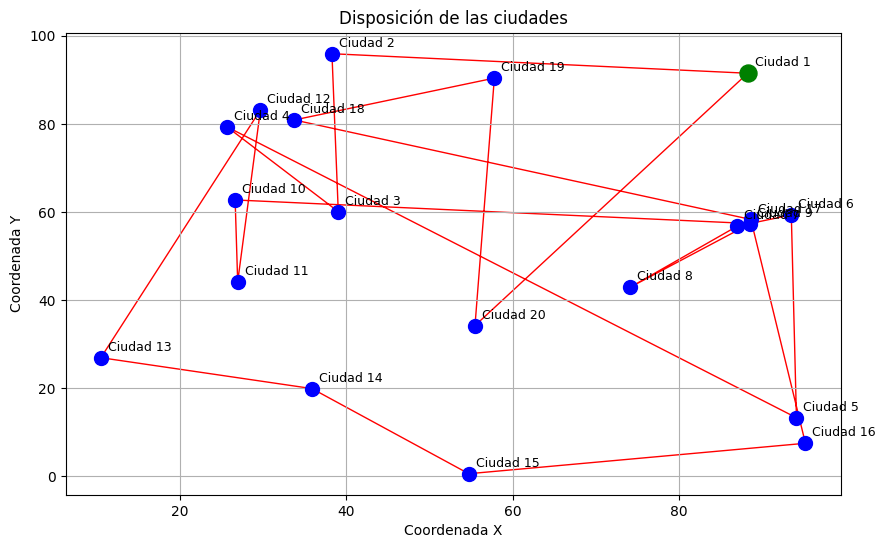

In [9]:
# Visualizar la disposición inicial de las ciudades
plot_tsp_route(
    problem_data.cities,
    list(range(num_cities)),
    problem_data.city_names,
    title="Disposición de las ciudades",
)

In [10]:
# Configuración del algoritmo genético
population_size = 100
n_generations = 200

# Crear y ejecutar el algoritmo genético personalizado para TSP
ga = TSPGeneticAlgorithm(
    pop_size=population_size,
    chromosome_length=num_cities,
    fitness_function=tsp_fitness,
    problem_data=problem_data,
    mutation_rate=0.02,
    crossover_rate=0.8,
    elitism=5,
    maximize=True,  # Mayor fitness = menor distancia
    binary=False,  # Representación continua para permutaciones
)

# Ejecutar algoritmo genético
best_chromosome, best_fitness = ga.run(n_generations, verbose=True)

Generación 1: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 10: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 20: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 30: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 40: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 50: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 60: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 70: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 80: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 90: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 100: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 110: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 120: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 130: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 140: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 150: Mejor fitness = 0.00, Fitness promedio = 0.00
Generación 160: Mej

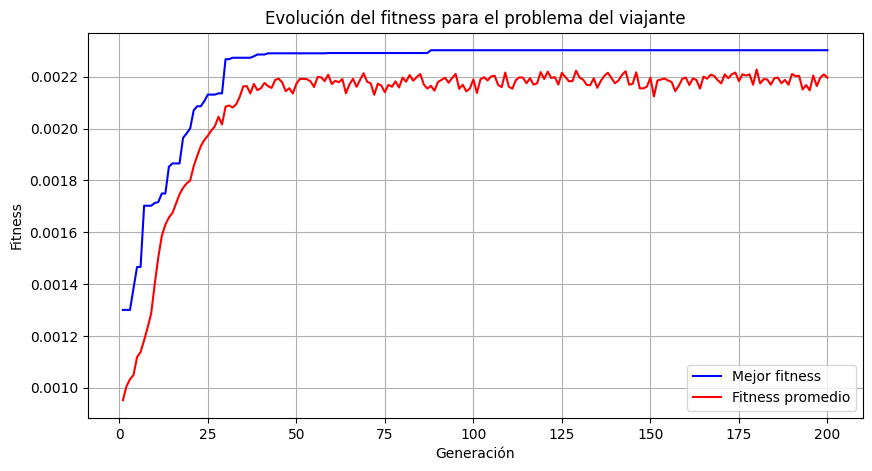

In [11]:
# Visualizar evolución del fitness
ga.plot_history(title="Evolución del fitness para el problema del viajante")


Resultados del Problema del Viajante:
Número de ciudades: 20
Distancia total de la ruta: 434.38

Ruta óptima encontrada:
1. Ciudad 5 → Ciudad 6 (46.04)
2. Ciudad 6 → Ciudad 17 (4.97)
3. Ciudad 17 → Ciudad 9 (0.93)
4. Ciudad 9 → Ciudad 7 (1.72)
5. Ciudad 7 → Ciudad 8 (18.87)
6. Ciudad 8 → Ciudad 20 (20.58)
7. Ciudad 20 → Ciudad 3 (30.63)
8. Ciudad 3 → Ciudad 4 (23.47)
9. Ciudad 4 → Ciudad 12 (5.55)
10. Ciudad 12 → Ciudad 18 (4.66)
11. Ciudad 18 → Ciudad 2 (15.70)
12. Ciudad 2 → Ciudad 19 (20.28)
13. Ciudad 19 → Ciudad 1 (30.45)
14. Ciudad 1 → Ciudad 10 (67.95)
15. Ciudad 10 → Ciudad 11 (18.61)
16. Ciudad 11 → Ciudad 13 (23.78)
17. Ciudad 13 → Ciudad 14 (26.30)
18. Ciudad 14 → Ciudad 15 (26.98)
19. Ciudad 15 → Ciudad 16 (41.02)
20. Ciudad 16 → Ciudad 5 (5.89)


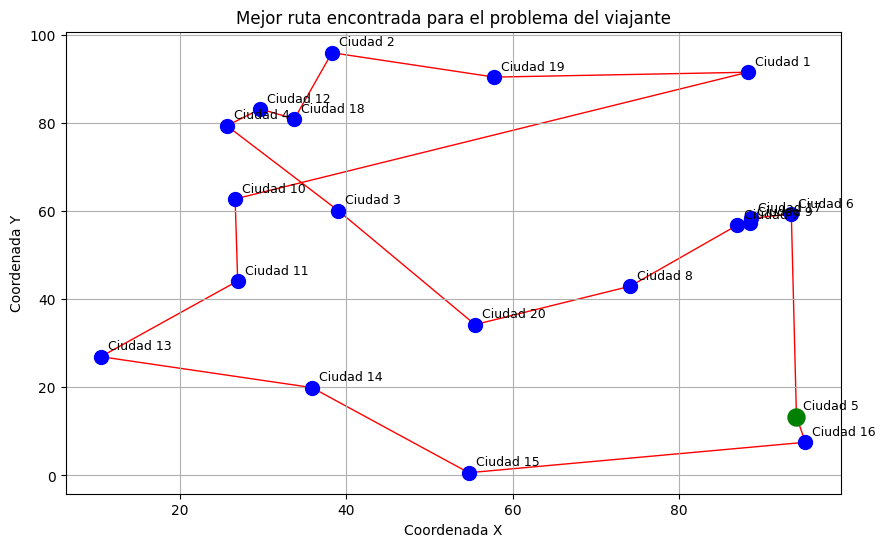

In [12]:
# Mostrar detalles de la solución
display_tsp_solution(ga.best_chromosome, problem_data)

## Save Results to Temp Directory

In [13]:
# Ensure temp directory exists
temp_dir = am.get_asset_path(AssetType.TEMP)
am.ensure_path_exists(temp_dir)

# Get the best route
best_route = decode_tsp_chromosome(ga.best_chromosome, num_cities)

# Create and save the figure
plt.figure(figsize=(10, 6))

# Plot the cities and route
x = problem_data.cities[:, 0].numpy()
y = problem_data.cities[:, 1].numpy()
plt.scatter(x, y, s=100, c="blue", zorder=2)

route_x = [x[best_route[i]] for i in range(len(best_route))] + [x[best_route[0]]]
route_y = [y[best_route[i]] for i in range(len(best_route))] + [y[best_route[0]]]
plt.plot(route_x, route_y, "r-", linewidth=1, zorder=1)

plt.scatter(x[best_route[0]], y[best_route[0]], s=150, c="green", zorder=3)

plt.title("TSP Solution (Saved)")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.grid(True)

# Get path for saving and save
save_path = am.get_temp("tsp_solution.png", absolute=True)
plt.savefig(save_path)
plt.close()

print(f"Saved results to: {save_path}")

Saved results to: c:\Users\fire\Documents\Code\python\ai\data\temp\tsp_solution.png



In [14]:
# Save fitness history plot
plt.figure(figsize=(10, 5))
generations = range(1, len(ga.best_fitness_history) + 1)
plt.plot(generations, ga.best_fitness_history, "b-", label="Mejor fitness")
plt.plot(generations, ga.avg_fitness_history, "r-", label="Fitness promedio")
plt.title("Evolución del fitness para TSP (guardado)")
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)

# Get path for saving and save
fitness_path = am.get_temp("tsp_fitness_history.png", absolute=True)
plt.savefig(fitness_path)
plt.close()

print(f"Saved fitness history to: {fitness_path}")

Saved fitness history to: c:\Users\fire\Documents\Code\python\ai\data\temp\tsp_fitness_history.png
